In [240]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [241]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])


# MNIST                                           
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
X_train, X_val= train_test_split(train, test_size=0.2, random_state=42)
trainLoader = torch.utils.data.DataLoader(X_train, batch_size=5000, shuffle=True, num_workers=2)


validationLoader = torch.utils.data.DataLoader(X_val, batch_size=10, shuffle=True, num_workers=2)
 

test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=False, num_workers=2)

In [242]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.images = []
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (divide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function()
#            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(1210, 150),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(150, 50),
            activation_function(),
            nn.Linear(50,10)
        )
    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        #if x.shape[0]<100:
        #    print(x.shape)
        self.images=(x.detach().numpy())
#         for val in x:
#             self.images.append(val.detach().numpy())
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [243]:

model = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=1e-6)

best_model = model
best_loss = 100
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    tr_correct = 0
    tr_total = 0
    val_correct = 0
    val_total = 0
    for batch_nr, (data, labels) in enumerate(trainLoader):
        
        # get the inputs; data is a list of [inputs, labels]
        labels_untrained = labels
        # forward + backward + optimize
        prediction = model.forward(data)
    
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print statistics
        running_loss += loss.item()
    
        if(loss < best_loss):
                best_loss = loss
                best_model = model
            
        elif(loss > best_loss):
            model = best_model
        
         # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                tr_correct+=1
            tr_total +=1
tr_accuracy = tr_correct/tr_total
print(f'Training accuracy:   {str(100*tr_accuracy)[:4]}%.')


Training accuracy:   10.4%.


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.003s...


E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.312268
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.806770
[t-SNE] KL divergence after 1000 iterations: 1.363915


E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\matplotlib\collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


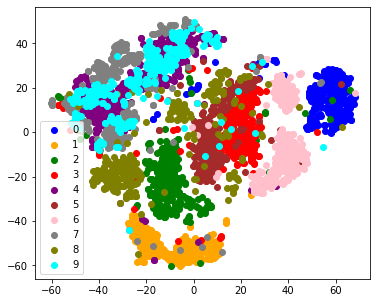

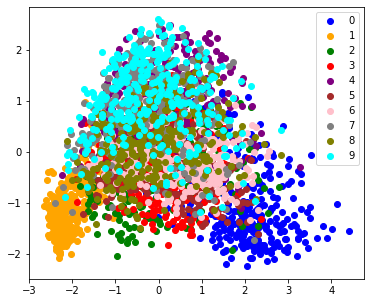

In [244]:
copy_data = model.images

pca = PCA(n_components=2)
pca.fit(copy_data)
X_untrained_PCA = pca.transform(copy_data)


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
X_untrained = tsne.fit_transform(copy_data)
numbers = [0,1,2,3,4,5,6,7,8,9]

colors = 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray','olive', 'cyan'   


plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    scatter = plt.scatter(X_untrained[labels_untrained[0:3000] == i, 0], X_untrained[labels_untrained[0:3000] == i, 1], c=c, label=label)
plt.legend(handles=scatter.legend_elements()[0], labels=numbers)


plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    scatter= plt.scatter(X_untrained_PCA[labels_untrained[0:3000] == i, 0], X_untrained_PCA[labels_untrained[0:3000] == i, 1], c=c, label=label)
plt.legend(handles=scatter.legend_elements()[0], labels=numbers)


In [245]:

model = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=1e-3)

best_model = model
best_loss = 100
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    tr_correct = 0
    tr_total = 0
    val_correct = 0
    val_total = 0
    for batch_nr, (data, labels) in enumerate(trainLoader):
        
        # get the inputs; data is a list of [inputs, labels]
        labels_untrained = labels
        # forward + backward + optimize
        prediction = model.forward(data)
    
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print statistics
        running_loss += loss.item()
    
        if(loss < best_loss):
                best_loss = loss
                best_model = model
            
        elif(loss > best_loss):
            model = best_model
        
         # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                tr_correct+=1
            tr_total +=1

    
    
    
    running_loss = 0.0
tr_accuracy = tr_correct/tr_total
print(f'Training accuracy:   {str(100*tr_accuracy)[:4]}%.')


Training accuracy:   87.0%.


E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.003s...
[t-SNE] Computed neighbors for 3000 samples in 0.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 4.720443
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.003281
[t-SNE] KL divergence after 1000 iterations: 1.255113


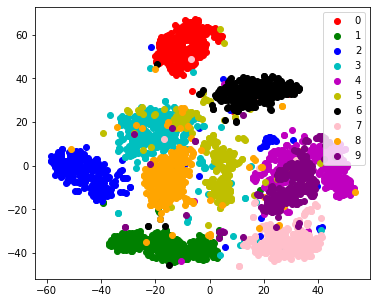

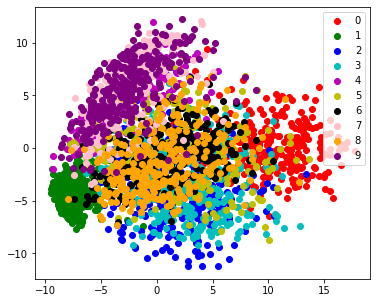

In [249]:
copy_data = model.images

pca = PCA(n_components=2)
pca.fit(copy_data)
X_untrained_PCA = pca.transform(copy_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
X_untrained = tsne.fit_transform(copy_data)
numbers = [0,1,2,3,4,5,6,7,8,9]

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained[labels_untrained[0:3000] == i, 0], X_untrained[labels_untrained[0:3000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[labels_untrained[0:3000] == i, 0], X_untrained_PCA[labels_untrained[0:3000] == i, 1], c=c, label=label)
plt.legend()
plt.show()